In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
from chandra.models.cnn import create_dataset
from chandra.metrics import F1_Score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
from skimage.io import imread
from tensorflow.keras.models import load_model

# Model Selection

## Reading the Models In

We need to read in all of our best-fit models and compare their performance on the validation set.  In the case of the k-nearest neighbors model, it is simple enough (and non-trivial to store), so we simply quickly retrain it here with the correct parameters

### k-Nearest Neighbors

In [3]:
train_info_file_path = Path('data').joinpath('preprocessed',
                                             'train_metadata.csv')
test_info_file_path = Path('data').joinpath('preprocessed',
                                             'test_metadata.csv')

full_train = pd.read_csv(train_info_file_path)
test_data = pd.read_csv(test_info_file_path)
train_data, val_data = train_test_split(full_train, test_size=0.2,
                                        shuffle=True,
                                        stratify=full_train.is_pneumonia,
                                        random_state=9473)

In [4]:
# Reading in k-NN data
X_train = [imread(path,as_gray=True) for path in train_data.resized_file_path]
y_train = np.array([pnu for pnu in train_data.is_pneumonia])
X_val = [imread(path,as_gray=True) for path in val_data.resized_file_path]
y_val = np.array([pnu for pnu in val_data.is_pneumonia])
X_test = [imread(path,as_gray=True) for path in test_data.resized_file_path]
y_test = np.array([pnu for pnu in test_data.is_pneumonia])

X_train = np.reshape(X_train, (np.shape(X_train)[0], -1))
X_test = np.reshape(X_test, (np.shape(X_test)[0], -1))
X_val = np.reshape(X_val, (np.shape(X_val)[0], -1))

knn_model = KNeighborsClassifier(n_neighbors=18)
knn_model.fit(X_train, y_train);

### Convolutional Neural Networks

In [5]:
# Read in CNNs

train_dataset = create_dataset(train_data.resized_file_path,
                               train_data.is_pneumonia,
                               batch_size=128)
val_dataset = create_dataset(val_data.resized_file_path,
                             val_data.is_pneumonia,
                             batch_size=128)

cnn_model = load_model('CNN_v1', custom_objects={'F1_Score':F1_Score})
tl_model = load_model('TL_v2', custom_objects={'F1_Score':F1_Score})

## Making Predictions and Evaluating Performance

In [6]:
knn_pred = knn_model.predict(X_val)
knn_conf_mat = confusion_matrix(y_val, knn_pred)
knn_f1 = f1_score(y_val, knn_pred)

In [7]:
cnn_pred = cnn_model.predict(val_dataset).squeeze()>=0.5
cnn_conf_mat = confusion_matrix(y_val, cnn_pred)
cnn_f1 = f1_score(y_val, cnn_pred)

8/8 [==============================] - 16s 2s/step


In [8]:
tl_pred = tl_model.predict(val_dataset).squeeze()>0.5
tl_conf_mat = confusion_matrix(y_val, tl_pred)
tl_f1 = f1_score(y_val, tl_pred)

8/8 [==============================] - 121s 15s/step


Text(0.5, 64.78588235294116, 'True')

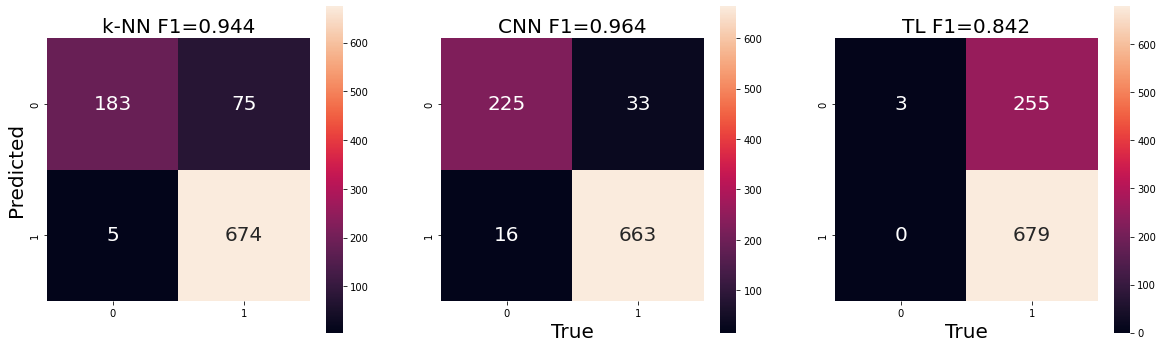

In [12]:
fig = plt.figure(figsize=(20, 6))
knn_sp = fig.add_subplot(131)
cnn_sp = fig.add_subplot(132)
tl_sp = fig.add_subplot(133)

sbn.heatmap(knn_conf_mat, ax=knn_sp, annot=True, 
            square=True, fmt='d', 
            annot_kws=dict(fontsize=20))
sbn.heatmap(cnn_conf_mat, ax=cnn_sp, annot=True,
            square=True, fmt='d',
            annot_kws=dict(fontsize=20))
sbn.heatmap(tl_conf_mat, ax=tl_sp, annot=True,
            square=True, fmt='d',
            annot_kws=dict(fontsize=20))

knn_sp.set_title(f'k-NN F1={knn_f1:.3f}', fontsize= 20)
knn_sp.set_ylabel('Predicted', fontsize= 20)

cnn_sp.set_title(f'CNN F1={cnn_f1:.3f}', fontsize= 20)
cnn_sp.set_xlabel('True', fontsize= 20)

tl_sp.set_title(f'TL F1={tl_f1:.3f}', fontsize= 20)
tl_sp.set_xlabel('True', fontsize= 20)

Here, we see that the CNN model does a much better job than the other two models at not mistaking normal x-rays for ones that should have been classified as having pneumonia.  This gain comes with only a slight decrease in the ability to correctly identify normal images, resulting in the highest F1 Score.  The TL model seems to classify nearly all of the objects as pneumonia, resulting in a poor fit.

# How well does our CNN do on the Test set?

In [10]:
test_dataset = create_dataset(test_data.resized_file_path,
                              test_data.is_pneumonia,
                              batch_size=128)

cnn_test_pred = cnn_model.predict(test_dataset).squeeze()>=0.5
cnn_test_conf_mat = confusion_matrix(y_test, cnn_test_pred)
cnn_test_f1 = f1_score(y_test, cnn_test_pred)

10/10 [==============================] - 9s 922ms/step


Text(0.5, 1.0, 'Test F1=0.966')

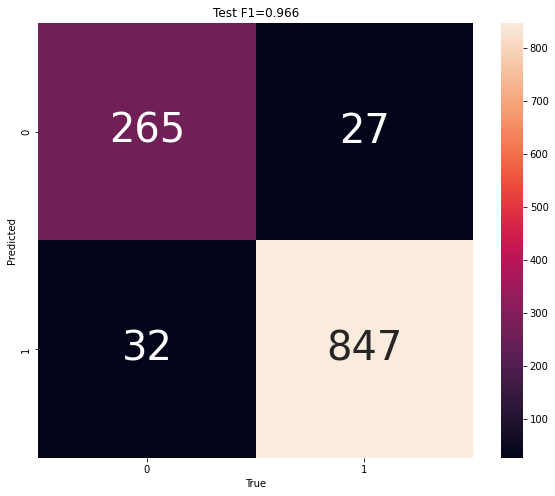

In [11]:
fig = plt.figure(figsize = (10, 8))
sp = fig.add_subplot(111)

sbn.heatmap(cnn_test_conf_mat, ax=sp,
            annot=True, square=True, fmt='d',
            annot_kws=dict(fontsize=40))
sp.set_xlabel('True')
sp.set_ylabel('Predicted')
sp.set_title(f'Test F1={cnn_test_f1:.3f}')

Our CNN model seems to do about as well on the test set as it did on the validation set!

## Conclusions

In conclusion, we find that a custom-trained convolutional neural network represents a substantive improvement over the other two models by decreasing the margin between the F1 score and its maximum possible value of 1. 